In [96]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.vis_data import *
from src.visualization.vis_model import *
from src.models.train_model import *
from src.models.predict_model import *
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Model Performance

In [3]:
data, model, fire_cols, zone_list, feat_imp = load_model1(city='Chiang Mai', pollutant='PM2.5', split_list=[0.7, 0.3])

rolling True
data no fire has shape (77747, 14)
model performance {'test_r2_score': 0.7087790905988873, 'test_mean_squared_error': 227.67283457136557, 'test_mean_absolute_error': 9.23587087862017}


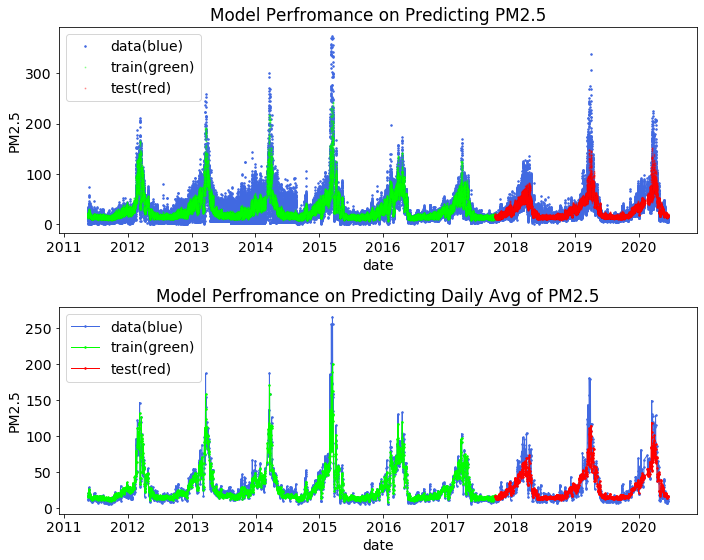

In [233]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=data, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

In [346]:
# calculate the average error
trn_error = cal_error(data, model, data_index=data.split_list[0])

# resample
ytrn_pred_df_avg = trn_error.resample('d').mean().dropna()
cal_scores(ytrn_pred_df_avg['actual'].values, ytrn_pred_df_avg['pred'].values, header_str='avg_trn_')

{'avg_trn_r2_score': 0.9450132986667232,
 'avg_trn_mean_squared_error': 35.925725806931965,
 'avg_trn_mean_absolute_error': 3.7745352329778226}

In [347]:
# calculate the average error
ytest_pred_df = cal_error(data, model, data_index=data.split_list[1])

# resample
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()
cal_scores(ytest_pred_df_avg['actual'].values, ytest_pred_df_avg['pred'].values, header_str='avg_test_')

{'avg_test_r2_score': 0.7828068417310021,
 'avg_test_mean_squared_error': 145.74247345984156,
 'avg_test_mean_absolute_error': 7.717591182233365}

## Average Error

Text(0.5, 1.0, 'error (by pollution season)')

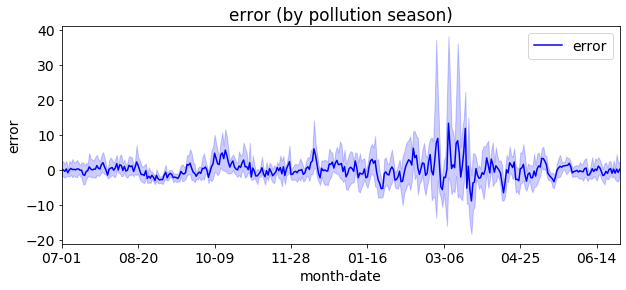

In [348]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'error', ax, plot_error=True, roll=False, agg='mean')
ax.set_title('error (by pollution season)')

Text(0.5, 1.0, 'rmse (by pollution season)')

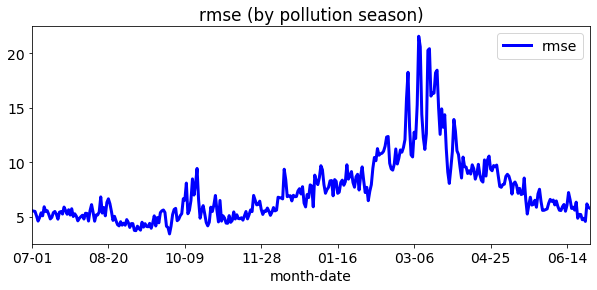

In [349]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'rmse', ax, plot_error=False, roll=True, agg='mean')
ax.set_title('rmse (by pollution season)')

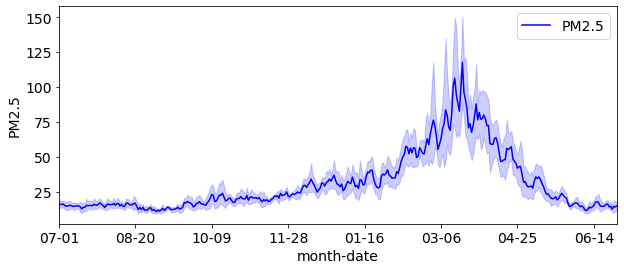

In [194]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(data.data, 'PM2.5', ax, plot_error=True, roll=False, agg='mean')

# Inference

In [102]:
inferer = Inferer(city_name='Chiang Mai', pollutant='PM2.5')

rolling_win 24
data no fire has shape (77747, 14)
raw model performance {'test_r2_score': 0.7087790905988873, 'test_mean_squared_error': 227.67283457136557, 'test_mean_absolute_error': 9.23587087862017}
daily avg training error {'avg_trn_r2_score': 0.9450132986667232, 'avg_trn_mean_squared_error': 35.925725806931965, 'avg_trn_mean_absolute_error': 3.7745352329778226}
daily avg test error {'avg_test_r2_score': 0.7828068417310021, 'avg_test_mean_squared_error': 145.74247345984156, 'avg_test_mean_absolute_error': 7.717591182233365}
max error 16.910217885946217
obtaining inference samples. This will take about 20 mins


In [105]:
inferer._get_data_sample(n_samples=100, step=5,day_err=10,hour_err=2)

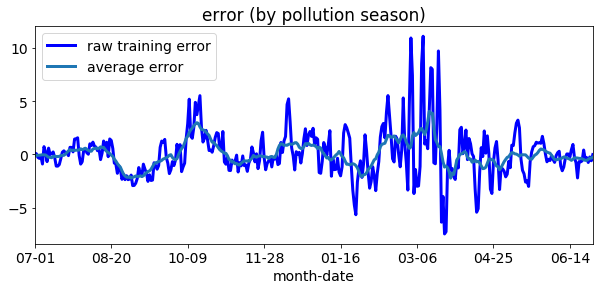

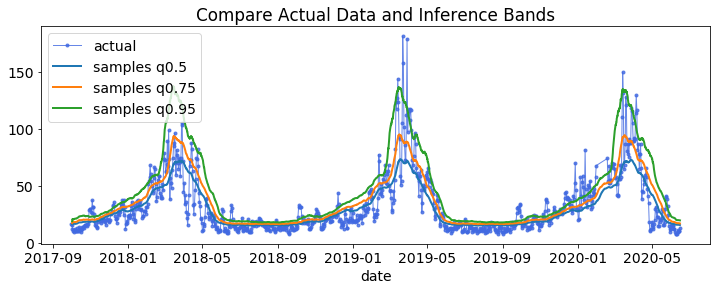

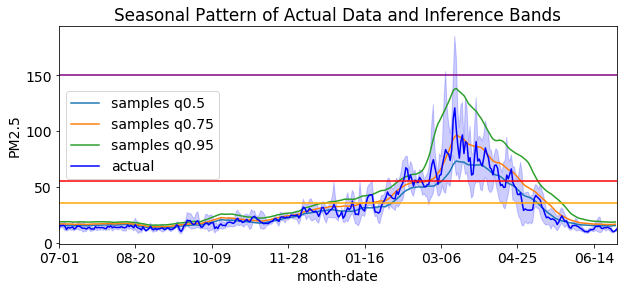

In [182]:
inferer.compare_inf_act()

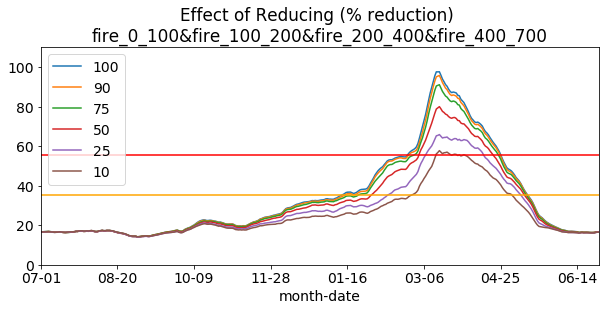

In [186]:
fea_effect = inferer.features_effect_season(features=['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700'], q=0.75, red_list=[0, 0.1, 0.25, 0.5, 0.75, 0.9])

In [176]:
%%time

features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5]
zone_list = inferer.zone_list
feature_list = []
columns_list = []
for i in range(1,6):
    fea = features[:i]
    feature_list.append(fea)
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    
fea_effect_3m = inferer.features_effect_sum(feature_list, q=0.75, red_list=[0, 0.1, 0.25, 0.5, 0.75, 0.9], time_range=[185,305],agg='mean' )
fea_effect_3m.columns = columns_list


Wall time: 3min 29s


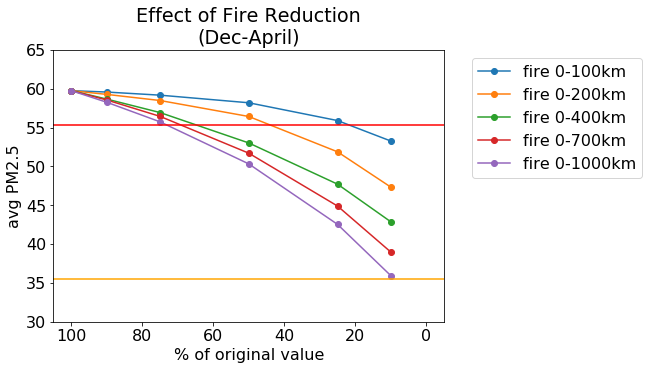

In [177]:
plt.figure(figsize=(7,5))
plt.title("Effect of Fire Reduction\n(Dec-April)")
columns_list = [fill(l,25) for l in fea_effect_3m.columns]
plt.plot(fea_effect_3m, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([30, 65])

for l, c in inferer.color_zip:
    plt.axhline(l, color=c)

In [183]:
%%time

features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5]
zone_list = inferer.zone_list
feature_list = []
columns_list = []
for i in range(1,6):
    fea = features[:i]
    feature_list.append(fea)
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    
fea_effect_mar = inferer.features_effect_sum(feature_list, q=0.75, red_list=[0, 0.1, 0.25, 0.5, 0.75, 0.9], time_range=[245,275],agg='mean' )


Wall time: 3min 28s


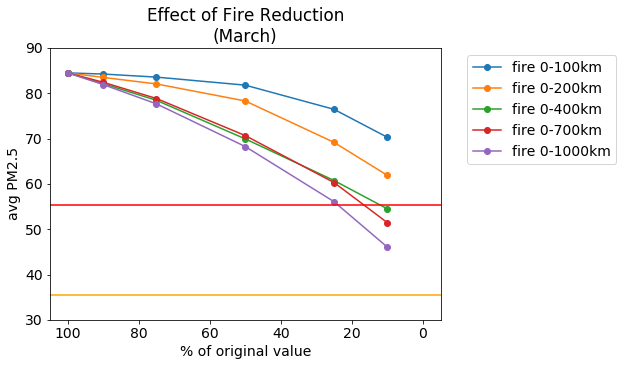

In [184]:
plt.figure(figsize=(7,5))
plt.title("Effect of Fire Reduction\n(March)")
columns_list = [fill(l,20) for l in fea_effect_3m.columns]
plt.plot(fea_effect_mar, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([30, 90])

for l, c in inferer.color_zip:
    plt.axhline(l, color=c)